In [1]:
import os
import pickle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np

import matplotlib.pyplot as plt
# import tifffile as tiff

In [31]:
# Function to load data from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'rb') as f:
            image, label = pickle.load(f)
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# Convert data to tf.data.Dataset
def create_tf_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset = create_tf_dataset(train_images, train_labels)
validation_dataset = create_tf_dataset(val_images, val_labels)
test_dataset = create_tf_dataset(test_images, test_labels)

# Batch and shuffle the datasets
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

(12, 32, 32) 1


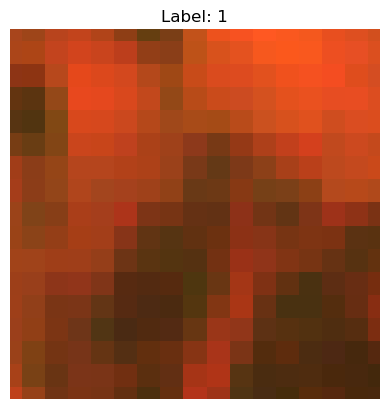

In [32]:
for images, labels in train_dataset.take(1):
    for i in range(1):
        print(images[i].shape, labels[i].numpy())
        image = images[i]
        label = labels[i]

        # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
        image = np.transpose(image, (1, 2, 0))  # (12, 32, 32) -> (32, 32, 12)

        # Select RGB bands (e.g., bands 4, 3, 2 from Sentinel-2, adjust if needed)
        rgb_image = np.stack([
            image[:, :, 3],  # Band 4 (Red)
            image[:, :, 2],  # Band 3 (Green)
            image[:, :, 1]   # Band 2 (Blue)
        ], axis=-1)

        # Normalize the RGB image for saving
        rgb_image = (rgb_image / np.max(rgb_image) * 255).astype(np.uint8)

        # Save the image as a TIFF file
        # tiff.imwrite('rgb_image.tiff', rgb_image)
        # print("Image saved as 'rgb_image.tiff'")

        # Display the RGB image
        plt.imshow(rgb_image)
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
        plt.show()


In [ ]:
#Use class weights in model to re-balance the data

In [ ]:
#Size of training data
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 12, 32, 32)
(32,)
(32, 32, 32, 12)


In [35]:
TARGET_SHAPE = (32, 32, 32,12)

def reshape_tensors(image_batch, labels_batch):
    image_batch = tf.reshape(image_batch, shape=TARGET_SHAPE)
    return image_batch, labels_batch

train_dataset = train_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(reshape_tensors, num_parallel_calls=tf.data.AUTOTUNE)


In [36]:
for image_batch, labels_batch in train_dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 32, 32, 12)
(32,)


In [37]:
img_height = 32
img_width = 32

In [38]:
batch_size = 32

In [39]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 12)),
  layers.Conv2D(16, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 12, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 12)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        27664     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        73760     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)         

In [ ]:
epochs=10
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10
 668/1673 [==========>...................] - ETA: 1:10 - loss: 0.3103 - accuracy: 0.8547